# Deep Q-Network for Cart-Pole.

In this assignment you are required to implement a Deep Q-Network agent, for the Cart-Pole problem.

You need to submit your code, along with a plot of the rewards during training, and a video of an episode with the trained agent.


__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for PyTorch, but you'll find it easy to adapt it to almost any Python-based deep learning framework.

In [ ]:
!pip install stable-baselines3 gym==0.22.0
!pip install pyglet==1.5.27
!pip install pyvirtualdisplay

In [ ]:
import os
import random
import numpy as np
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !apt-get -qq install -y xvfb
    os.environ['DISPLAY'] = ':1'

display = Display(visible=0, size=(400, 300))
display.start()


## Cart Pole

In this environment a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

The observation consists of the cart position, cart velocity, pole angle and pole angular velocity.

There are 2 actions corresponding to moving the cart to the left and to the right.

See full description [here](https://www.gymlibrary.dev/environments/classic_control/cart_pole/).



In [ ]:
ENV_NAME = "CartPole-v0"

def make_env(seed=None):
    # some envs are wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


observation dim (4,) number of actions 2


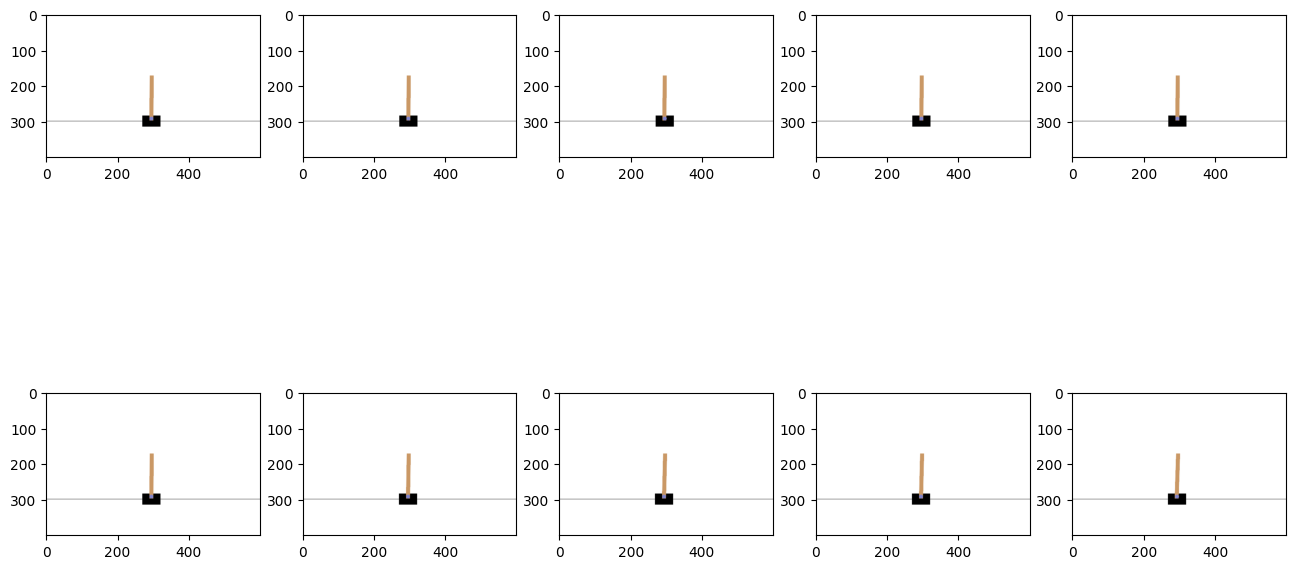

In [ ]:
env = gym.make(ENV_NAME)
obs = env.reset()


n_actions = env.action_space.n
obs_dim = obs.shape
print("observation dim", obs_dim, "number of actions", n_actions)

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

## Random Agent

Here we implement a random agent to use in the 'evaluate' function, that runs the agent through multiple epsiodes.

In [ ]:
class RandomAgent():
    def __init__(self, n_actions):
        self.n_actions = n_actions


    def get_qvalues(self, states):
        return np.random.normal(size=(1,self.n_actions,))

    def sample_actions(self, qvalues):
        return np.random.randint(self.n_actions, size=(1,))

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
              break

        rewards.append(reward)
    return np.mean(rewards)

agent = RandomAgent(n_actions)
mean_reward = evaluate(env, agent, greedy=True, n_games=5)

## Video generation

In [ ]:
# run sessions

import gym.wrappers
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

n_games = 1 # how many games to record

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    env_monitor.reset()
    sessions = [evaluate(env_monitor, agent, n_games=3, greedy=False) for _ in range(10)]


In [ ]:
# show video

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices (if n_games>1)

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

## Assignment

Implement a DQN agent that contains:
1. A neural network that predicts the q-values for a given observation.
2. An experience replay buffer where all transitions are added.
3. A target Q-network that is formed by periodically copying the weights of the main Q-nework.

You will also need to implement the training loop, and submit a figure showing the reward as a function of the training step, and a video showing an episode with the trained agent.

In [ ]:
!pip install pyvirtualdisplay
!apt-get -qq install -y xvfb

In [ ]:
import time
import io
import base64
import glob
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from gym.wrappers import Monitor
from IPython.display import HTML, display
from pyvirtualdisplay import Display
from pyvirtualdisplay import Display as PyVirtualDisplay

In [ ]:
virtual_display = PyVirtualDisplay(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.buffer)


In [ ]:

# DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, replay_buffer):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters())
        self.criterion = nn.MSELoss()

    def select_action(self, state, epsilon=0.1):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.model(state)
            action = q_value.max(1)[1].item()
        else:
            action = random.randrange(self.action_dim)
        return action

    def optimzie_model(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        state = torch.FloatTensor(state)
        next_state = torch.FloatTensor(next_state)
        action = torch.LongTensor(action)
        reward = torch.FloatTensor(reward)
        done = torch.FloatTensor(done)

        q_values = self.model(state)
        next_q_values = self.model(next_state)
        q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
        next_q_value = next_q_values.max(1)[0]
        expected_q_value = reward + 0.99 * next_q_value * (1 - done)

        loss = self.criterion(q_value, expected_q_value.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [ ]:
env = make_env()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
replay_buffer = ReplayBuffer(10000)
agent = DQNAgent(state_dim, action_dim, replay_buffer)

num_episodes = 300
batch_size = 128
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
epsilon = epsilon_start

rewards = []
averages = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.select_action(state, epsilon=epsilon)
        next_state, reward, done, _ = env.step(action)
        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.optimzie_model(batch_size)

        if done:
            rewards.append(total_reward)
            avg_reward = np.mean(rewards[-100:])
            averages.append(avg_reward)
            print("Episode:",episode, "Total Reward:",total_reward, "Average Reward:",avg_reward)
            epsilon = max(epsilon_end, epsilon_decay * epsilon)
            break

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


Episode: 0 Total Reward: 25.0 Average Reward: 25.0
Episode: 1 Total Reward: 10.0 Average Reward: 17.5
Episode: 2 Total Reward: 20.0 Average Reward: 18.333333333333332
Episode: 3 Total Reward: 14.0 Average Reward: 17.25
Episode: 4 Total Reward: 19.0 Average Reward: 17.6
Episode: 5 Total Reward: 88.0 Average Reward: 29.333333333333332
Episode: 6 Total Reward: 14.0 Average Reward: 27.142857142857142
Episode: 7 Total Reward: 11.0 Average Reward: 25.125
Episode: 8 Total Reward: 23.0 Average Reward: 24.88888888888889
Episode: 9 Total Reward: 14.0 Average Reward: 23.8
Episode: 10 Total Reward: 19.0 Average Reward: 23.363636363636363
Episode: 11 Total Reward: 29.0 Average Reward: 23.833333333333332
Episode: 12 Total Reward: 17.0 Average Reward: 23.307692307692307
Episode: 13 Total Reward: 50.0 Average Reward: 25.214285714285715
Episode: 14 Total Reward: 19.0 Average Reward: 24.8
Episode: 15 Total Reward: 10.0 Average Reward: 23.875
Episode: 16 Total Reward: 16.0 Average Reward: 23.411764705882

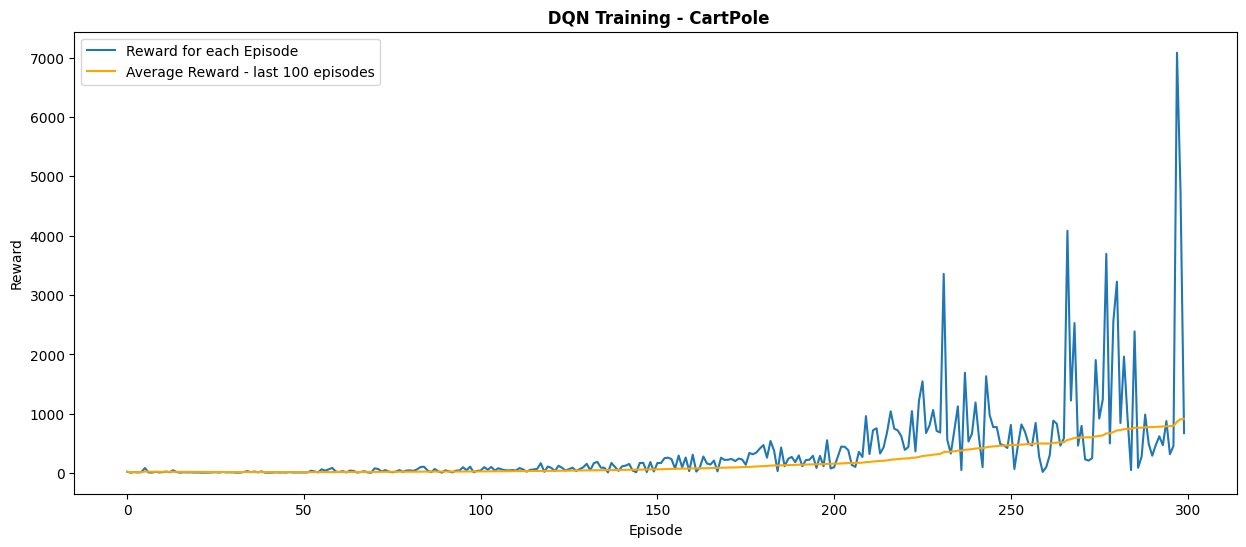

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(rewards, label="Reward for each Episode")
plt.plot(averages, label="Average Reward - last 100 episodes", color="orange")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title(" DQN Training - CartPole",fontweight="bold")
plt.legend()
plt.show()


In [ ]:
def evaluate(env, agent, n_games=1, greedy=True, t_max=10000):
    total_rewards = []
    for _ in range(n_games):
        state = env.reset()
        total_reward = 0
        for _ in range(t_max):
            action = agent.select_action(state, epsilon=0.0) if greedy else random.randrange(agent.action_dim)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        total_rewards.append(total_reward)
    return np.mean(total_rewards)


env_eval = Monitor(make_env(), './video', force=True, video_callable=lambda episode: True)
eval_reward = evaluate(env_eval, agent, n_games=1)
env_eval.close()
print("Evaluated Reward: ", eval_reward)


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


Evaluated Reward:  10000.0
